# Consensus Analysis of iForest output

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam
import logomaker
from tqdm import tqdm

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl, predict_editing_custom_thrs

Matplotlib is building the font cache; this may take a moment.


In [2]:
def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

In [3]:
# define inputs
ref_cc_filepath = "/lustre/bio_running/curlcakes_runs/refs/cc.fasta"
cc2_dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/cc2.model_iForestcc1_pretrained_results/df_CT_predicted_aggregated.tsv"

## CC2

In [4]:
cc2_dfCTaggr = pd.read_table(cc2_dfCTaggr_filepath)
# drop unwanted minus strand sites
cc2_dfCTaggr = cc2_dfCTaggr.query("strand != '-'")
# predict editing using multiple thresholds retrieved from cc1 sample
cc2_dfCTaggr = predict_editing_custom_thrs(cc2_dfCTaggr, "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1_cc2_merged.iforest.freq_thresholds.tsv", ref_cc_filepath, 0.02)
cc2_dfCTaggr

100%|██████████| 2495/2495 [00:00<00:00, 11195.26it/s]


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,37,+,4,0,1377,0.002905,0.000000,GGCTG,0
1,chr1,47,+,181,59,11601,0.015602,0.005086,GTCGA,0
2,chr1,55,+,86,70,11742,0.007324,0.005962,ATCAA,0
3,chr1,61,+,110,5,11306,0.009729,0.000442,AACCT,0
4,chr1,62,+,156,17,11792,0.013229,0.001442,ACCTT,0
...,...,...,...,...,...,...,...,...,...,...
2793,chr4,2719,+,488,72,138447,0.003525,0.000520,GACAA,0
2794,chr4,2722,+,56369,3666,137772,0.409147,0.026609,AACCG,0
2795,chr4,2723,+,3255,261,138874,0.023439,0.001879,ACCGA,0
2797,chr4,2727,+,698,41,139638,0.004999,0.000294,AACAA,0


In [5]:
cc2_dfCTaggr.y_hat.value_counts()

0    2495
Name: y_hat, dtype: int64

In [6]:
cc2_dfCTaggr.query("y_hat == 1")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat


100%|██████████| 2495/2495 [00:00<00:00, 257126.43it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.
100%|██████████| 2470/2470 [00:00<00:00, 259517.31it/s]


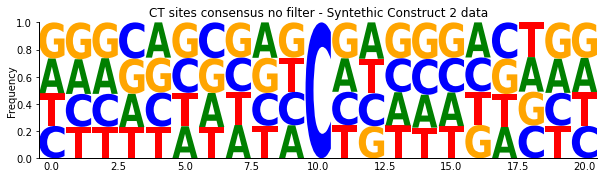

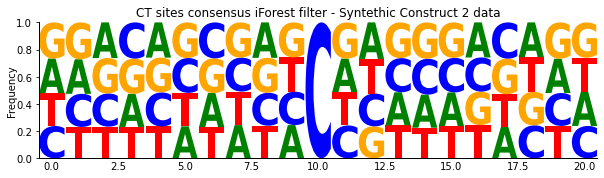

In [7]:
produce_consensus(cc2_dfCTaggr.query("Tfreq_native > 0"), "CT sites consensus no filter - Syntethic Construct 2 data", 10, ref_cc_filepath)
produce_consensus(cc2_dfCTaggr.query("Tfreq_corrected > 0"), "CT sites consensus iForest filter - Syntethic Construct 2 data", 10, ref_cc_filepath)
#produce_consensus(cc2_dfCTaggr.query("y_hat == 1"), "CT sites consensus iForest filter {above threshold} - Syntethic Construct 2 data", 10, ref_cc_filepath)